# Logistic Regression

####  Ανάλυση IMDB δεδομένων


Ορίζουμε τις **υπερπαραμέτρους** που θα χρησιμοποιηθούν για την ανάπλαση των δωσμένων δεδομένων και αντλούμε τα δεδομένα από τη βάση δεδομένων IMDB, αγνοώντας τις πιο συχνά χρησιμοποιούμενες λέξεις n και τις λιγότερες χρησιμοποιούμενες λέξεις k. (υπερπαράμετροι).

In [72]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report

m = 2500  
n = 200    
k = 20     
infogain = False
g = 800 

(x_train_imdb, y_train_imdb), (x_test_imdb, y_test_imdb) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train_imdb])
x_test_imdb = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test_imdb])





In [35]:
from sklearn.model_selection import train_test_split
X_train, X_dev, y_train_t, y_dev = train_test_split(x_train_imdb, y_train_imdb,
                                                  test_size=0.1)

### Δημιουργία δυαδικών διανυσμάτων

Μετατρέπουμε τα αντλημένα δεδομένα σε δυαδικά διανύσματα. Οι δυνατές τιμές είναι 0 και 1. Τιμή 1 συνεπάγεται ότι η αντίστοιχη λέξη περιέχεται στο κείμενο, ενώ τιμή 0 συνεπάγεται ότι δεν περιέχεται.

In [73]:
binary_vectorizer = CountVectorizer(binary=True)
x_train_imdb_binary = binary_vectorizer.fit_transform(x_train_imdb)
x_test_imdb_binary = binary_vectorizer.transform(x_test_imdb)
print(
    'Vocabulary size:', len(binary_vectorizer.vocabulary_)
)

x_train_imdb_binary = x_train_imdb_binary.toarray()
x_test_imdb_binary = x_test_imdb_binary.toarray()


Vocabulary size: 2240


#### Αυτή είναι μια υλοποίηση του κέρδους πληροφορίας, σε αυτόν τον αλγόριθμο η εφαρμογή του IG δεν έχει κανένα ή ένα ελαφρύ αποτέλεσμα στις μετρήσεις της λογιστικής παλινδρόμησης, επομένως δεν το χρησιμοποιούμε πολύ

In [4]:
from math import log 

if  infogain:
  def IG(class_, feature):
    classes = set(class_)

    Hc = 0
    for c in classes:
      pc = list(class_).count(c)/len(class_)
      Hc += - pc * log(pc, 2)
    feature_values = set(feature)

    Hc_feature = 0 # Αρχικοποίηση της εντροπίας του χαρακτηριστικού Hc_feature.
    for feat in feature_values:
      
      # Υπολογισμός του P(X=x)
      pf = list(feature).count(feat)/len(feature)
      indices = [i for i in range(len(feature)) if feature[i] == feat]
      clasess_of_feat = [class_[i] for i in indices]
      for c in classes:
          # Υπολογισμός του P(C=c|X=x)
          pcf = clasess_of_feat.count(c)/len(clasess_of_feat)
          if pcf != 0: 
              # Υπολογισμός του - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
              temp_H = - pf * pcf * log(pcf, 2)
              #sum for all values of C (class) and X (values of specific feature)
              Hc_feature += temp_H
    # Υπολογισμός του information gain.
    ig = Hc - Hc_feature
    return ig

  # Επιλογή των g πιο σημαντικών χαρακτηριστικών.
  ig = [(i, IG(y_train_imdb, x_train_imdb_binary[:, i])) for i in range(len(x_train_imdb_binary[0]))]
  ig.sort(key=lambda x: x[1], reverse=True)
  ig = ig[:g]
  # Προσαρμογή των δεδομένων εκπαίδευσης και ελέγχου.
  x_train_binary = x_train_imdb_binary[:, [i[0] for i in ig]]
  x_test_binary = x_test_imdb_binary[:, [i[0] for i in ig]]

##### Αλγόριθμος Logistic Regression.
##### Οι ιδανικότεροι παράμετροι του  μοντέλου είναι 0,1 για lambda_value, 100 για max_iter και 0,001 για eta. Σε αυτήν την υλοποίηση χρησιμοποιούμε στοχαστική ανάβαση  κλίσης, προσπαθούμε να φτάσουμε σε ολικά μέγιστα κινούμενοι αργά ανοδικά με αποτέλεσμα να μεγιστοποιούμε τη συνάρτηση κόστους για να εκπεδεύσουμε το μοντέλο μας. Απαραίτητη προηπόθεση για να εκπαιδεύσουμε το μοντέλο μας είναι να  εφαρμόζουμε τη ανάβαση κλήσης στα βάρη πολλαπλασιαζόμενα με την τιμή eta. Η κύρια ιδέα αυτού του αλγορίθμου είναι να προβλέψει την έξοδο με τη βοήθεια της σιγμοειδούς συνάρτησης και του κατωφλιού.

In [74]:
class LogisticRegression:
    def __init__(self, lambda_value = 0.1, max_iter = 100,eta=0.001):
        self.lambda_value = lambda_value
        self.max_iter = max_iter
        self.weights = None
        self.regularization = 0
        self.eta = eta

   
         

    def fit(self, X, y):
        samples = X.shape[0]
        features = X.shape[1]
        self.weights = np.zeros(features)

        for t in range(self.max_iter):
            linear = np.dot(X, self.weights) 
            y_pred = self.sigmoid(linear)

            gradient_ascent = np.mean((y-y_pred)*X.T, axis=1)-self.lambda_value*sum(self.weights**2)
            
            self.weights += self.eta * gradient_ascent
                  
            
           
    def predict(self, X):
        linear = np.dot(X, self.weights)
        y_pred = self.sigmoid(linear)
        y_pred_classes = [1 if i>0.5 else 0 for i in y_pred]
        return y_pred_classes
    
    def sigmoid(self, t):
        return 1 / (1 + np.exp(-t))

### Classification report

In [75]:
log = LogisticRegression()

log.fit(x_train_imdb_binary, y_train_imdb)
print(classification_report(y_test_imdb,log.predict(x_test_imdb_binary)))


              precision    recall  f1-score   support

           0       0.81      0.86      0.83     12500
           1       0.85      0.79      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000



In [77]:
from sklearn.linear_model import LogisticRegression
lg=LogisticRegression()
lg.fit(x_train_imdb_binary, y_train_imdb)
print(classification_report(y_test_imdb,lg.predict(x_test_imdb_binary)))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.85     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



### Classification table

In [57]:
from visualizations import *

data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)


data_table = classification_table(data,x_train_imdb_binary)
ipd.display(data_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.82,0.81,0.78,0.77,0.89,0.88,0.83,0.82
10000,0.80,0.79,0.87,0.87,0.71,0.69,0.78,0.77
15000,0.77,0.76,0.89,0.89,0.62,0.60,0.73,0.72
20000,0.79,0.78,0.88,0.88,0.67,0.65,0.76,0.74
25000,0.74,0.74,0.91,0.91,0.54,0.52,0.68,0.66


###

In [47]:
log = LogisticRegression()

log.fit(X_train, y_train_t)
print(classification_report(y_dev,log.predict(X_dev)))

ValueError: could not convert string to float: '[oov] could [oov] understand why [oov] [oov] felt [oov] necessary [oov] [oov] [oov] most [oov] accent [oov] through [oov] [oov] [oov] [oov] [oov] back [oov] [oov] [oov] [oov] fact [oov] rather [oov] [oov] [oov] [oov] me [oov] [oov] [oov] what [oov] probably [oov] fine performance [oov] him very [oov] no other actor [oov] actress seemed [oov] [oov] such [oov] [oov] accent [oov] whilst [oov] [oov] always rated [oov] [oov] [oov] [oov] fine actor [oov] would [oov] class [oov] [oov] [oov] being [oov] [oov] [oov] best [oov] [oov] however [oov] [oov] my [oov] [oov] [oov] [oov] [oov] [oov] other comments made re [oov] [oov] which [oov] [oov] found very interesting [oov] [oov] [oov] now read [oov] book'

In [38]:
print(data)

{'estimator': 'LogisticRegression', 'split_size': 5000, 'splits': 5, 'test_predictions': [0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0

### Πρόγραμμα εύρεσης βέλτιστων παραμέτρων

### Σε αυτό το κομμάτι εκπαίδευουμε τον αλγόριθμο μας για υποψίφιες τιμες των eta , lambda_value και max_iter και με γνώμονα το accuracy score επιλέγουμε τις βέλτιστες τιμές


In [37]:
from visualizations import *


Eta=[0.01, 0.001]
L=[1, 0.1, 0.01, 0.001]
iter=[1000,100,50]
maxAccuracy = -float('inf')


for h in Eta:
    for l in L:
        for i in iter:
            log.eta=h
            log.lambda_value=l
            log.max_iter=i
            log.fit(X_train,y_train_t)
            c_accuracy=accuracy_score(y_dev,log.predict(X_dev))
            if(c_accuracy>maxAccuracy):
                maxAccuracy = c_accuracy
                bestl=l
                besth=h
                bestIter=i

print(bestl)
print(besth)
print(bestIter)

0.001
0.01
1000


## Διαγράμματα μετρικών ανάλυσης αλγορίθμου

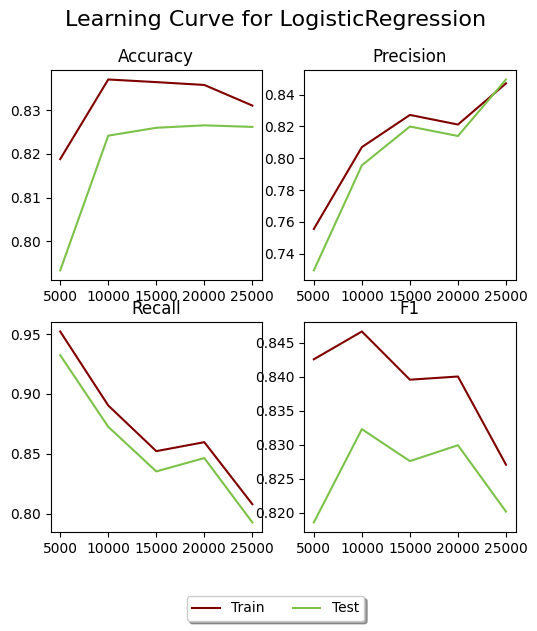

In [9]:
plot = classification_plots(data)


#### Πίνακας διαφορών ανάμεσα στον LogisticRegression του SK Learn και της υλοποίησης μας

In [29]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression

logistic_data = classification_data(LogisticRegression(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
logistic_data['estimator'] = 'SKLogisticRegression'
logistic_table = classification_table(logistic_data,x_train_imdb_binary)
difference_table = abs(logistic_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=logistic_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.170000,0.030000,0.230000,0.090000,0.040000,0.100000,0.150000,0.000000
10000,0.120000,0.010000,0.150000,0.030000,0.070000,0.030000,0.110000,0.000000
15000,0.090000,0.010000,0.100000,0.020000,0.090000,0.000000,0.090000,0.010000
20000,0.080000,0.020000,0.100000,0.030000,0.070000,0.000000,0.080000,0.020000
25000,0.080000,0.020000,0.060000,0.010000,0.110000,0.060000,0.080000,0.030000


### Διαγράμματα διαφορών ανάμεσα στον LogisticRegression του SK Learn και της υλοποίησης μας

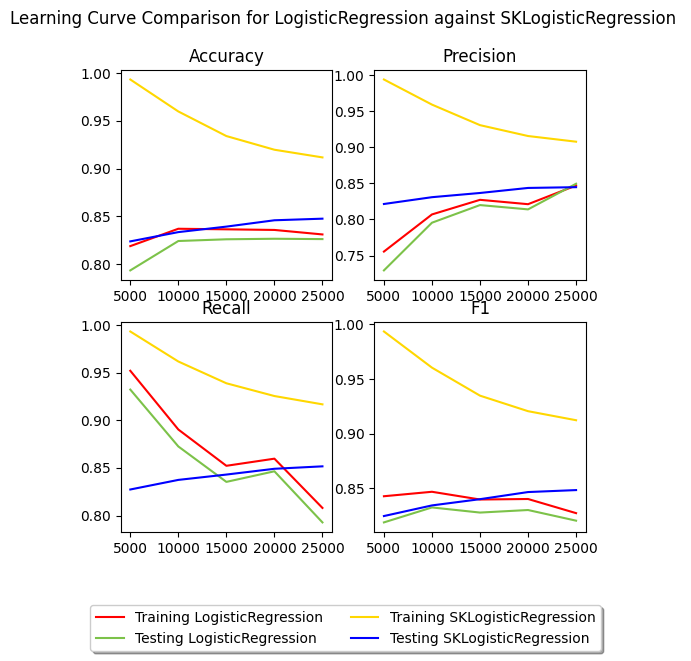

In [30]:
plot = classification_plots_compare(data,logistic_data)

### Πίνακας διαφορών ανάμεσα στον LogisticRegression  και τον SGDClassifier

In [31]:
from sklearn.linear_model import SGDClassifier

linear_data = classification_data(SGDClassifier(), x_train_imdb_binary, y_train_imdb, x_test_imdb_binary, y_test_imdb, 5)
linear_data['estimator'] = 'SGDClassifier'
linear_table = classification_table(linear_data, x_train_imdb_binary)
difference_table = abs(linear_table - data_table)
difference_table = difference_table.style.set_caption('Classification Table Difference for {estimator} against {estimator_2}'.format(estimator=data['estimator'], estimator_2=linear_data['estimator']))
ipd.display(difference_table)

,Train Accuracy,Test Accuracy,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
5000,0.180000,0.010000,0.240000,0.080000,0.050000,0.140000,0.160000,0.020000
10000,0.130000,0.000000,0.170000,0.020000,0.080000,0.060000,0.120000,0.020000
15000,0.100000,0.000000,0.110000,0.010000,0.100000,0.000000,0.100000,0.000000
20000,0.090000,0.010000,0.110000,0.030000,0.070000,0.010000,0.090000,0.010000
25000,0.090000,0.020000,0.060000,0.020000,0.120000,0.080000,0.090000,0.030000


### Διαγράμματα διαφορών ανάμεσα στον LogisticRegression  και τον SGDClassifier

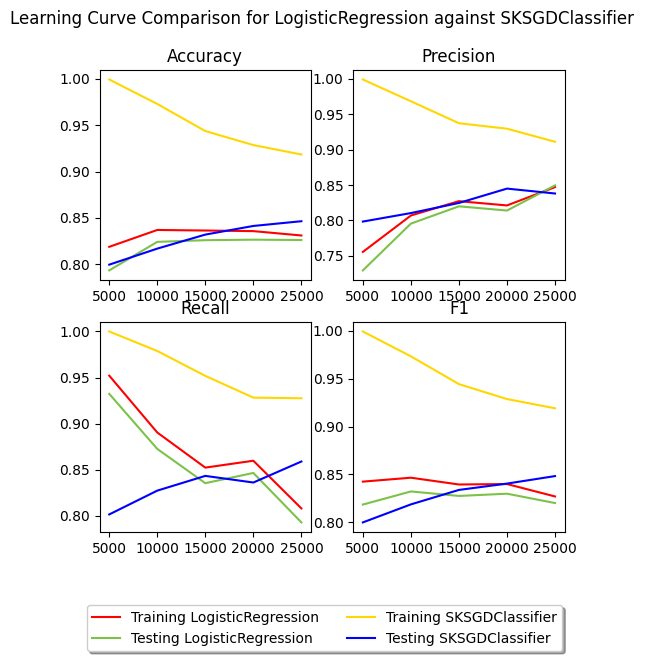

In [25]:
plot = classification_plots_compare(data,linear_data)

In [71]:

from sklearn.model_selection import train_test_split

N = [50, 100, 200, 300]
K = [0, 20, 50, 80]
M = [500, 2000, 2500, 3000]

binary_vectorizer = CountVectorizer(binary=True)
minK = 0
minN = 0
minM = 0
maxAccuracy = -float('inf')

for m in M:
    for n in N:
        for k in K:
            (x_trainn, y_trainn), (x_testt, y_testt) = tf.keras.datasets.imdb.load_data(num_words=m-k, skip_top=n)
            x_trainn, x_dev, y_trainn, y_dev = train_test_split(x_trainn, y_trainn, test_size=0.2)
            word_index = tf.keras.datasets.imdb.get_word_index()

            index2word = dict((i + 3, word) for (word, i) in word_index.items())
            index2word[0] = '[pad]'
            index2word[1] = '[bos]'
            index2word[2] = '[oov]'

            x_trainn = np.array([' '.join([index2word[idx] for idx in text]) for text in x_trainn])
            x_dev = np.array([' '.join([index2word[idx] for idx in text]) for text in x_dev])

            x_trainn_binary = binary_vectorizer.fit_transform(x_trainn)
            x_val_binary = binary_vectorizer.transform(x_dev)

            x_trainn_binary = np.array(x_trainn_binary.toarray())
            x_val_binary = np.array(x_val_binary.toarray())
            
            
            log.fit(x_trainn_binary, y_trainn)
            predicted_values = log.predict(x_val_binary)
            print("For M={}, N={} and K={}:".format(m, n, k))
            acc = accuracy_score(y_dev, predicted_values)
            print('Accuracy:', acc)
            if acc > maxAccuracy:
                maxAccuracy = acc
                minN = n
                minK = k
                minM = m

print("\nBest model parameters are:\n\tN: {}\n\tK:{} \n\tM: {}".format(minN, minK, minM))



For M=500, N=50 and K=0:
Accuracy: 0.6946
For M=500, N=50 and K=20:
Accuracy: 0.7124
For M=500, N=50 and K=50:
Accuracy: 0.6768
For M=500, N=50 and K=80:
Accuracy: 0.693
For M=500, N=100 and K=0:
Accuracy: 0.7254
For M=500, N=100 and K=20:
Accuracy: 0.7202
For M=500, N=100 and K=50:
Accuracy: 0.7168
For M=500, N=100 and K=80:
Accuracy: 0.6986
For M=500, N=200 and K=0:
Accuracy: 0.778
For M=500, N=200 and K=20:
Accuracy: 0.7732
For M=500, N=200 and K=50:
Accuracy: 0.7508
For M=500, N=200 and K=80:
Accuracy: 0.7424
For M=500, N=300 and K=0:
Accuracy: 0.7596
For M=500, N=300 and K=20:
Accuracy: 0.739
For M=500, N=300 and K=50:
Accuracy: 0.7112
For M=500, N=300 and K=80:
Accuracy: 0.7096
For M=2000, N=50 and K=0:
Accuracy: 0.7448
For M=2000, N=50 and K=20:
Accuracy: 0.7422
For M=2000, N=50 and K=50:
Accuracy: 0.749
For M=2000, N=50 and K=80:
Accuracy: 0.6962
For M=2000, N=100 and K=0:
Accuracy: 0.7874
For M=2000, N=100 and K=20:
Accuracy: 0.7384
For M=2000, N=100 and K=50:
Accuracy: 0.7678